## Example of usage of ESBM models

This notebook provides an example of usage of the code in this repo for applying Extended Stochastic Block Models (ESBM) and Degree-Corrected ESBM to a weighted bipartite network.

In [22]:
from src.analysis.models.baseline import Baseline
from src.analysis.models.esbm_rec import Esbm
from src.analysis.models.dc_esbm_rec import Dcesbm
from src.analysis.utilities.plotting_functions import plot_heatmap
from src.analysis.utilities.valid_functs import generate_val_set
import matplotlib.pyplot as plt

#### Generate data from models

In this section we show how the models we defined can be used to generate data. 

In particular ESBM model refers to a bipartite version of the nonparametric Stochastic Block Models detailed in Legramanti et al. (2020) where each entry of the adjacnecy matrix $y_{ui}$ for the network is modelled as:
$$
\begin{split}
\mathbf{z}, \mathbf{q} &\sim \text{Gibbs-type prior}\\
\theta_{h, k}|a, b &\sim \text{Gamma}(a, b)\\
y_ui \mid z, q, \Theta &\sim \text{Poisson}(\theta_{h, k})
\end{split}
$$

The DC-ESBM model is a degree correction version that takes into account degree heterogeneity among the nodes of the network:
$$
\begin{split}
    \mathbf{z}, \mathbf{q} &\sim \text{Gibbs-type} \\
    \phi_h\mid \gamma, \mathbf{z} \sim \text{Dirichlet}(\gamma \mathbf{1}_{n_h}) &\quad
    \phi_k \mid \gamma, \mathbf{q} \sim \text{Dirichlet}(\gamma \mathbf{1}_{n_k}) \\
    \eta_u = n_{z_u} \phi_{z_u, u} &\quad \eta_i = n_{q_i} \phi_{q_i, i} \\
    \theta_{h k}\mid a, b \sim& \text{Gamma}(a, b)\\
    y_{ui} \mid \Theta, \mathbf{z}, \mathbf{q}, \eta_u, \eta_i \sim& \text{Poisson}(\eta_i \theta_{z_u q_i} \eta_u)\\
  \end{split}
$$


randomly initialising data


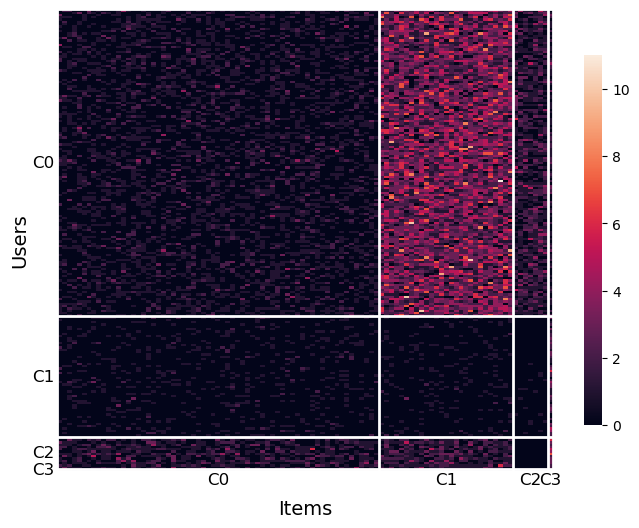

In [23]:
#plain esbm
params = {
    'num_users': 200,
    'num_items': 100,
    'scheme_type': 'DP',
    'user_clustering': 'random',
    'item_clustering': 'random',
    'seed':42
}

model_esbm = Esbm(**params)
plot_heatmap(model_esbm, size=(8, 6))


randomly initialising data


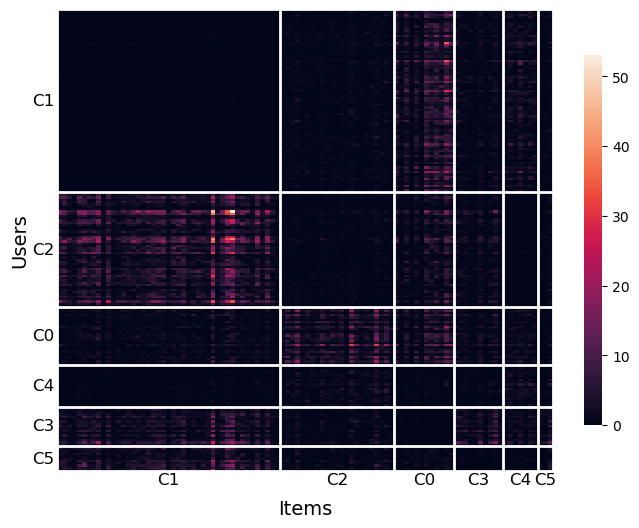

In [24]:
# degree-corrected version
params_dc = {
    'num_users': 200,
    'num_items': 100,
    'scheme_type': 'DP',
    'user_clustering': 'random',
    'item_clustering': 'random',
    'seed':4,
    'degree_param_users': 2,
    'degree_param_items': 2
}

model_esbmdc = Dcesbm(**params_dc)
plot_heatmap(model_esbmdc, size=(8, 6))

In [25]:
print('ESBM model log-likelihood:', model_esbm.compute_log_likelihood())
print('DC-ESBM model log-likelihood:', model_esbmdc.compute_log_likelihood())

ESBM model log-likelihood: -10975.056665684657
DC-ESBM model log-likelihood: 9395.409697026938


#### Example of fitting a model

By fitting the model we mean running the gibbs sampler to obatin samples from the posterior distribution and estimating the clustering structure by minimizing the Variation of Information (for details see the full text in `results/text/`)

In [26]:
true_data = model_esbmdc.Y.copy()
Y_train, Y_val = generate_val_set(true_data, size=0.1, seed=42, only_observed=False)

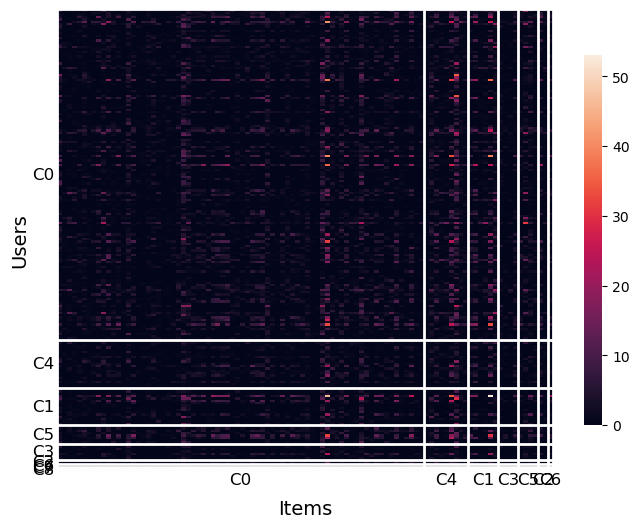

In [27]:
model = Dcesbm(
    num_users=Y_train.shape[0],
    num_items=Y_train.shape[1],
    scheme_type='DP',
    scheme_param=2,
    user_clustering='random',
    item_clustering='random',
    seed=1,
    Y=Y_train,
    degree_param_users=2,
    degree_param_items=2,
    device='cpu'
)

plot_heatmap(model, size=(8, 6))

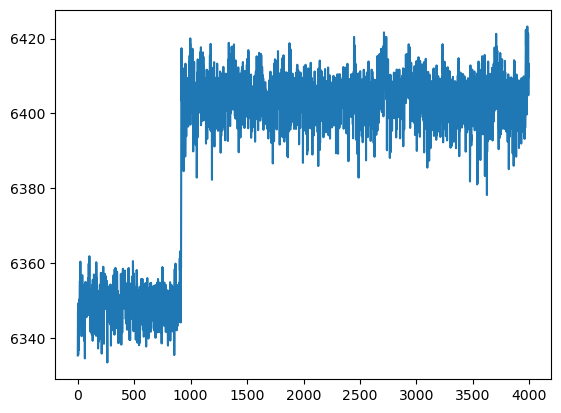

In [28]:
out = model.gibbs_train(n_iters=4000, verbose=0)
plt.plot(model.train_llk[5:])

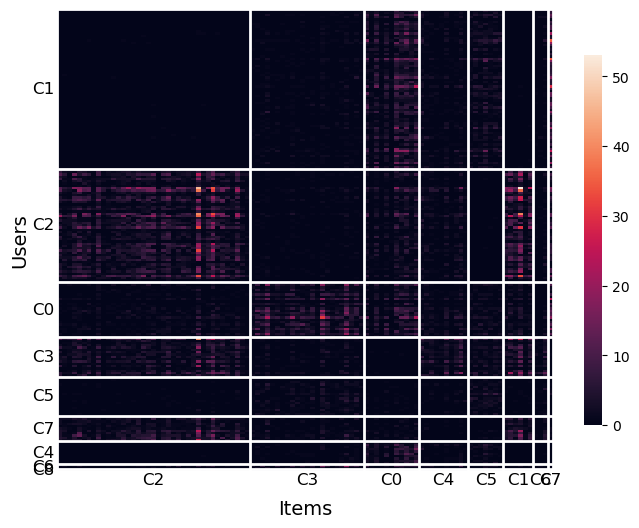

In [29]:
estimated = model.estimate_cluster_assignment_vi(burn_in=2000, thinning=5)
estimated_users = estimated[0]
estimated_items = estimated[1]
vi_users = estimated[2]
vi_items = estimated[3]
plot_heatmap(model, size=(8, 6))

#### Prediction example

After running the Gibbs sampler and obtaining estimates of the unknown quantities we can use the reslts to generate:
- point prediction for pairs $(u, i)$ 
- recommendations based on the estimated clustering structure .

In [30]:
# point predictions
pairs = [(Y_val[i][0], Y_val[i][1]) for i in range(3)]
out = model.point_predict((pairs))
for i in range(len(out)):
    print(f'Predicted value for user {pairs[i][0]} and item {pairs[i][1]}: {out[i]:.4f}. True value: {Y_val[i][2]}')

Predicted value for user 102 and item 51: 0.4937. True value: 1
Predicted value for user 92 and item 14: 1.1165. True value: 2
Predicted value for user 106 and item 71: 0.1492. True value: 0


In [31]:
# recommend 5 items for user 0
recs = model.predict_k(0, k=5)
recs

[array([34, 68,  4, 57,  3])]